# Question 5: Changes year to year

This notebook aims to answer the fifth question of the project.

Year to year:

- Has there been an overall increase or reduction in crime?

- Has a certain type of offence seen a significant decrease or increase?

## Initial setup

In [41]:
# Dependencies
from pathlib import Path 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings

warnings.simplefilter('ignore', st.ConstantInputWarning)


In [32]:
def corr_from_df(col_name1, col_name2, df):
    try:
        a = df[col_name1].astype(float)
        b = df[col_name2].astype(float)

        correlation = st.pearsonr(a, b)
        return correlation
    except ValueError:
        return [float('nan'), float('nan')]

def print_corr_from_df(col_name1, col_name2, df):
    correlation = corr_from_df(col_name1, col_name2, df)

    if correlation[1] < 0.001:
        print(f"The Pearson's correlation for {col_name1} and {col_name2} is:\n\
        \t{correlation[0]:.2f}\t(p < 0.001)\n")
    else:


        print(f"The Pearson's correlation for {col_name1} and {col_name2} is:\n\
        \t{correlation[0]:.2f}\t(p = {correlation[1]:.3f})\n")

In [6]:
# Read in data
df = pd.read_csv(Path('..', 'resources', 'mci_no_duplicates_2014_and_over.csv'))

# Keep only the relevant columns, rename them and drop na
df = (df[['OCC_YEAR', 'LOCATION_TYPE', 'PREMISES_TYPE', 'OFFENCE', 'MCI_CATEGORY']]
    .rename(
        columns={
            'OCC_YEAR': 'Year',
            'LOCATION_TYPE': 'Location Type',
            'PREMISES_TYPE': 'Premises Type',
            'MCI_CATEGORY': 'Category',
            'OFFENCE': 'Offence',
        }
    )
)


# Make year a string 
df['Year'] = (df['Year']
    .astype('string')
    .str.replace('.0', '',regex=False)
)

df.head()

,Year,Location Type,Premises Type,Offence,Category
0,2014,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,B&E,Break and Enter
1,2014,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault
2,2014,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Theft Over,Theft Over
3,2014,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault,Assault
4,2014,Bar / Restaurant,Commercial,Assault Bodily Harm,Assault


## By year

In [7]:
# general counts by year
year_df = (df
    .groupby('Year', as_index=False)
    .size()
    .rename(columns={'size': 'Number of events'})
)
year_df

,Year,Number of events
0,2014,30202
1,2015,30641
2,2016,31157
3,2017,32790
4,2018,34772
5,2019,37114
6,2020,32456
7,2021,32114
8,2022,37226


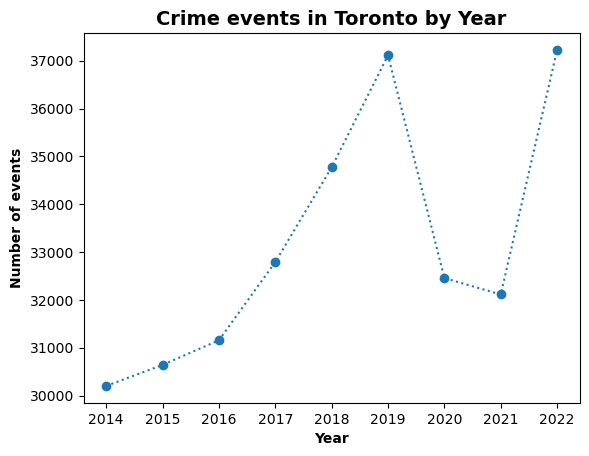

In [39]:
fig, ax = plt.subplots()

ax.plot(
    year_df['Year'],
    year_df['Number of events'],
    'o:'
)

plt.xlabel('Year', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto by Year',
    fontdict={'weight': 700, 'size': 14}
)

plt.show()

In [8]:
# print correlation
print_corr_from_df('Year', 'Number of events', year_df)

The Pearson's correlation for Year and Number of events is:
    	0.68	(p=0.043)



## By category

In [9]:
# count by category and year
year_cat_df = (df
    .groupby(['Year', 'Category'], as_index=False)
    .size()
    .rename(columns={'size': 'Number of events'})
)
year_cat_df.head(10)

,Year,Category,Number of events
0,2014,Assault,15294
1,2014,Auto Theft,3485
2,2014,Break and Enter,7216
3,2014,Robbery,3193
4,2014,Theft Over,1014
5,2015,Assault,16547
6,2015,Auto Theft,3090
7,2015,Break and Enter,6934
8,2015,Robbery,3028
9,2015,Theft Over,1042


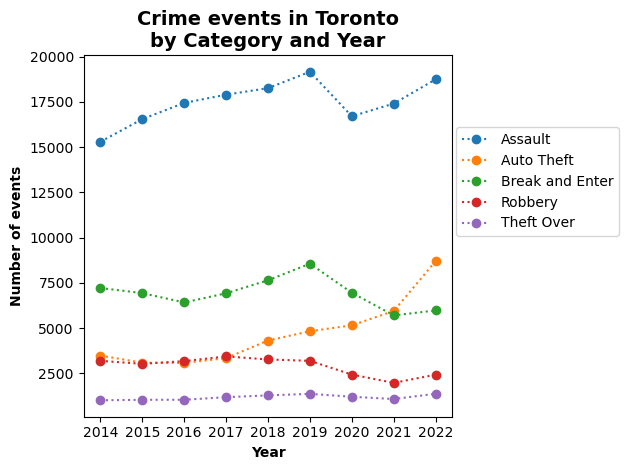

In [11]:
# Visualize
# List ofcategories
cats = list(year_cat_df['Category'].unique())

fig, ax = plt.subplots()

for cat in cats:
    this_data = year_cat_df.loc[year_cat_df['Category'] == cat]
    # add this category to plot
    ax.plot(
        this_data['Year'],
        this_data['Number of events'],
        'o:',
        label=cat
    )

plt.xlabel('Year', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto\nby Category and Year',
    fontdict={'weight': 700, 'size': 14}
    )
plt.legend(loc=(1.01, 0.5))
plt.tight_layout()
plt.show()

In [91]:
# loop through categories and calculate correlation
for cat in cats:
    this_data = year_cat_df.loc[year_cat_df['Category'] == cat]
    print(f"Category: {cat}")
    print_corr_from_df('Year', 'Number of events', this_data)

Category: Assault
The Pearson's correlation for Year and Number of events is:
        	0.62	(p = 0.077)

Category: Auto Theft
The Pearson's correlation for Year and Number of events is:
        	0.88	(p = 0.002)

Category: Break and Enter
The Pearson's correlation for Year and Number of events is:
        	-0.32	(p = 0.408)

Category: Robbery
The Pearson's correlation for Year and Number of events is:
        	-0.73	(p = 0.026)

Category: Theft Over
The Pearson's correlation for Year and Number of events is:
        	0.67	(p = 0.048)



## By subcategory

In [85]:
year_subcat_df = (df
    .groupby(['Year', 'Category', 'Offence'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

year_subcat_df.head()


,Year,Category,Offence,Number of events
0,2014,Assault,Administering Noxious Thing,29
1,2014,Assault,Aggravated Aslt Peace Officer,1
2,2014,Assault,Aggravated Assault,262
3,2014,Assault,Aggravated Assault Avails Pros,3
4,2014,Assault,Air Gun Or Pistol: Bodily Harm,1


### Assault

In [86]:
year_assault_df = year_subcat_df.loc[year_subcat_df['Category'] == 'Assault']
year_assault_df.head()

,Year,Category,Offence,Number of events
0,2014,Assault,Administering Noxious Thing,29
1,2014,Assault,Aggravated Aslt Peace Officer,1
2,2014,Assault,Aggravated Assault,262
3,2014,Assault,Aggravated Assault Avails Pros,3
4,2014,Assault,Air Gun Or Pistol: Bodily Harm,1


Category: Break and Enter
Subcategory: B&E W'Intent
The Pearson's correlation for Year and Number of events is:
        	-0.66	(p = 0.052)



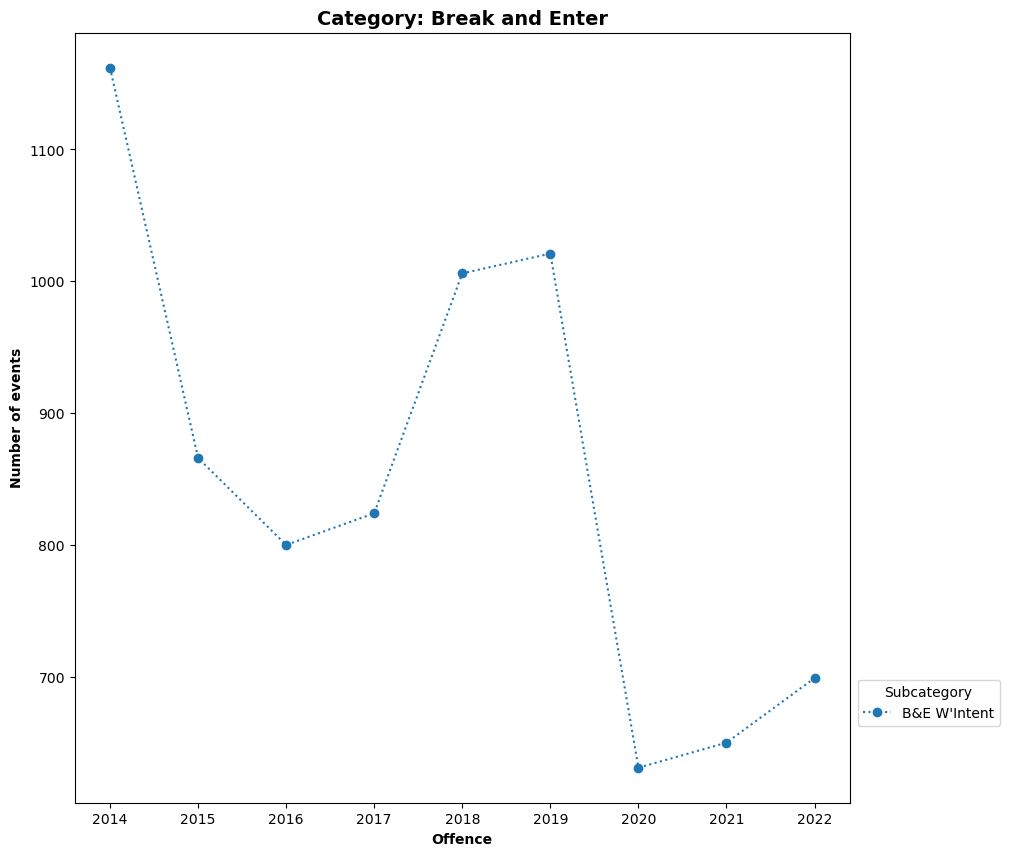

In [96]:
# Visualize
min_count = 0
max_count = 150
# max_count = max(year_offence_count['Number of events']) + 1
# only show moderate and
limitcorr = 0.5

cat = cats[2]
this_data = year_subcat_df.loc[year_subcat_df['Category'] == cat]
print(f"Category: {cat}")
offences = list(this_data['Offence'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for offence in offences:
    
    this_data_off = this_data.loc[this_data['Offence'] == offence]


    if any(this_data_off['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_off)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Subcategory: {offence}")
            print_corr_from_df('Year', 'Number of events', this_data_off)
            ax.plot(
                this_data_off['Year'],
                this_data_off['Number of events'],
                'o:',
                label=offence
            )
ax.legend(loc=(1.01, 0.1), title='Subcategory')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Category: ' + cat,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Offence', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()



Category: Robbery
Subcategory: Robbery - Business
The Pearson's correlation for Year and Number of events is:
        	0.79	(p = 0.011)

Subcategory: Robbery - Financial Institute
The Pearson's correlation for Year and Number of events is:
        	-0.59	(p = 0.096)

Subcategory: Robbery - Home Invasion
The Pearson's correlation for Year and Number of events is:
        	-0.86	(p = 0.003)

Subcategory: Robbery - Mugging
The Pearson's correlation for Year and Number of events is:
        	-0.94	(p < 0.001)

Subcategory: Robbery - Other
The Pearson's correlation for Year and Number of events is:
        	-0.73	(p = 0.026)

Subcategory: Robbery - Purse Snatch
The Pearson's correlation for Year and Number of events is:
        	-0.94	(p < 0.001)

Subcategory: Robbery - Swarming
The Pearson's correlation for Year and Number of events is:
        	-0.91	(p < 0.001)

Subcategory: Robbery - Taxi
The Pearson's correlation for Year and Number of events is:
        	-0.83	(p = 0.006)

Subcategory

The Pearson's correlation for Year and Number of events is:
        	0.90	(p < 0.001)



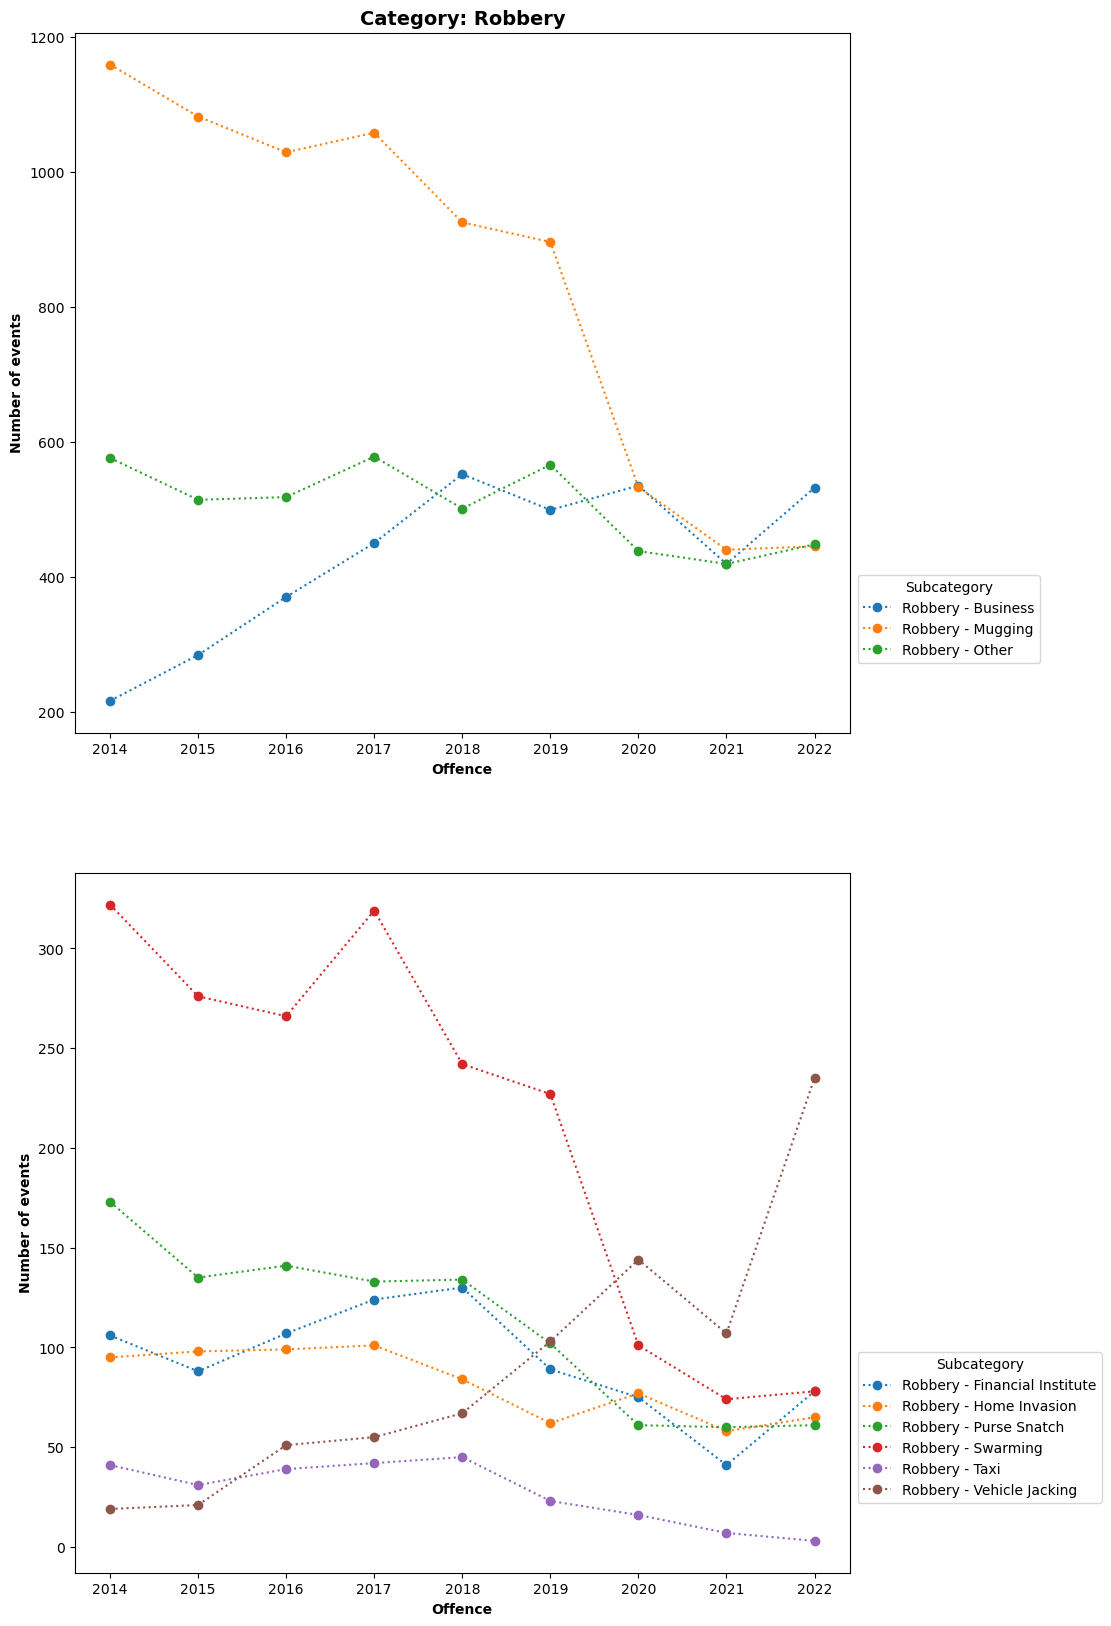

Category: Theft Over
Subcategory: Theft From Mail / Bag / Key
The Pearson's correlation for Year and Number of events is:
        	0.68	(p = 0.042)

Subcategory: Theft From Motor Vehicle Over
The Pearson's correlation for Year and Number of events is:
        	0.80	(p = 0.009)

Subcategory: Theft Of Utilities Over
The Pearson's correlation for Year and Number of events is:
        	-0.60	(p = 0.289)

Subcategory: Theft Over - Bicycle
The Pearson's correlation for Year and Number of events is:
        	-0.58	(p = 0.169)



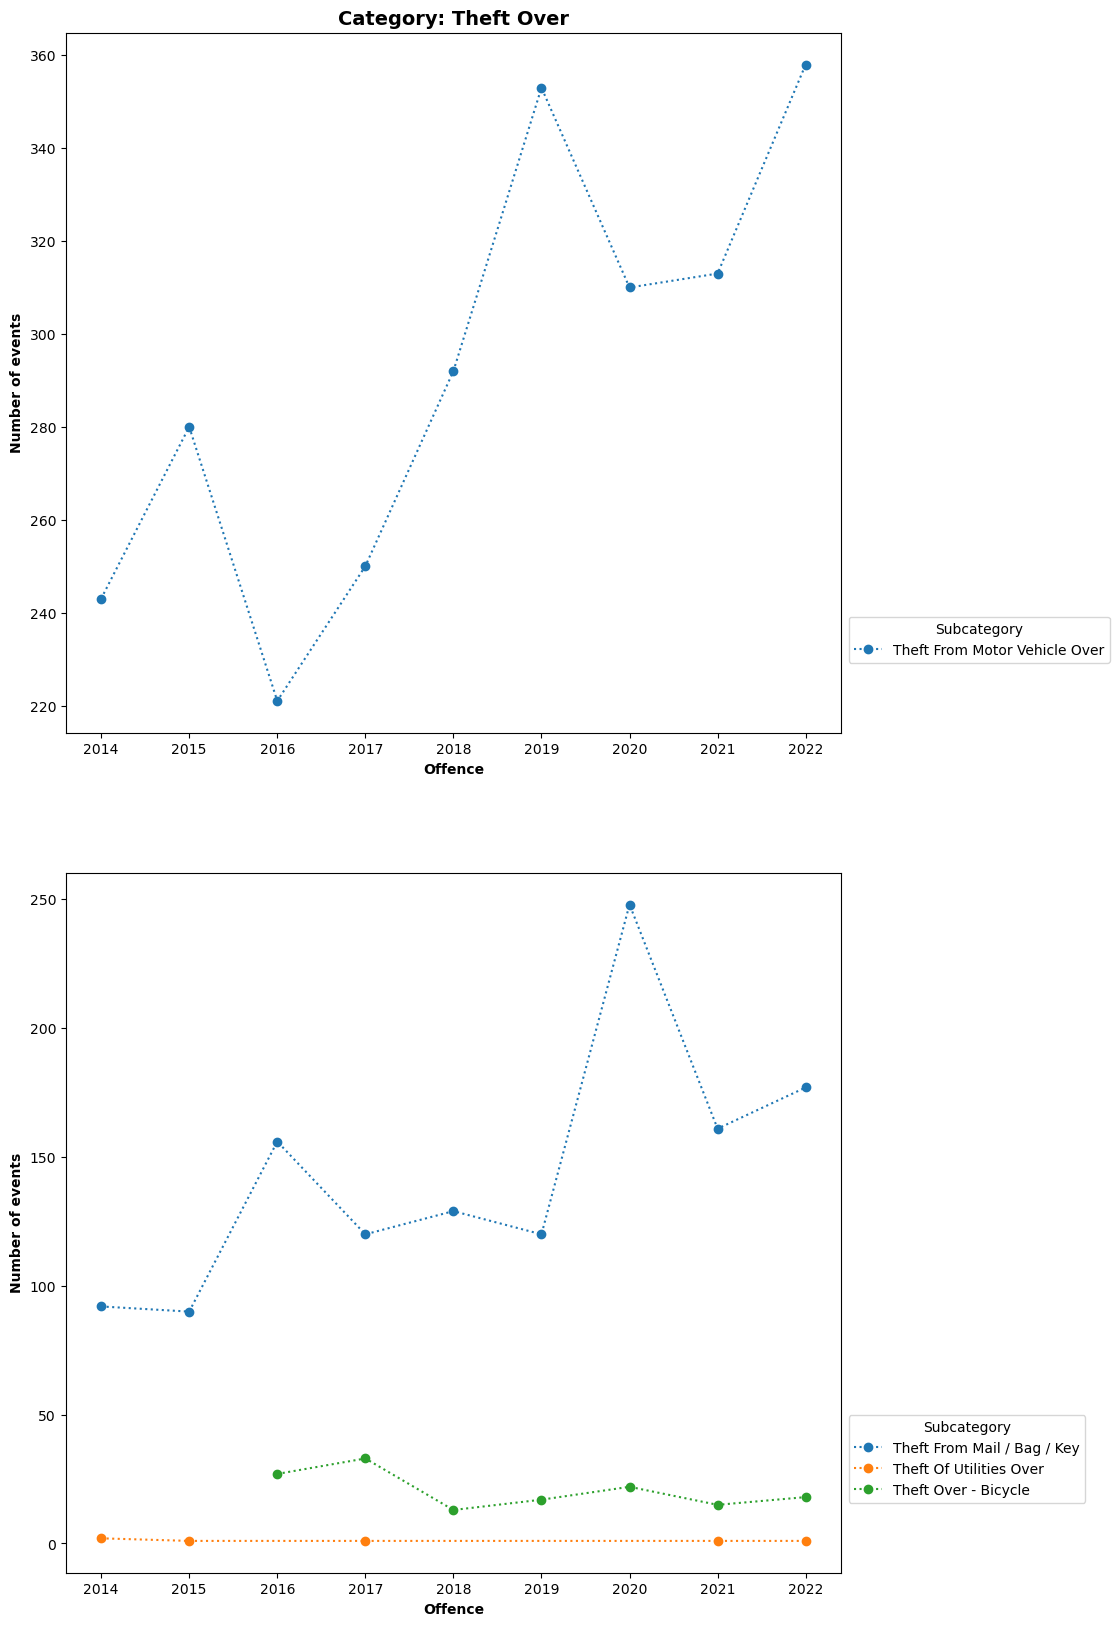

In [97]:
# Visualize
min_count = 0
max_count = 150
# max_count = max(year_offence_count['Number of events']) + 1
# only show moderate and
limitcorr = 0.5

for cat in cats[3:5]:
    this_data = year_subcat_df.loc[year_subcat_df['Category'] == cat]
    print(f"Category: {cat}")
    offences = list(this_data['Offence'].unique())
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 20))
    for offence in offences:
        
        this_data_off = this_data.loc[this_data['Offence'] == offence]


        if any(this_data_off['Number of events'] > min_count):
            if any(this_data_off['Number of events'] < max_count):
                ax = ax2
            else:
                ax = ax1
            correlation = corr_from_df('Year', 'Number of events', this_data_off)
            if correlation[0] ** 2 >= limitcorr ** 2:
                print(f"Subcategory: {offence}")
                print_corr_from_df('Year', 'Number of events', this_data_off)
                ax.plot(
                    this_data_off['Year'],
                    this_data_off['Number of events'],
                    'o:',
                    label=offence
                )
    ax1.legend(loc=(1.01, 0.1), title='Subcategory')
    ax2.legend(loc=(1.01, 0.1), title='Subcategory')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_title(
        'Category: ' + cat,
        fontdict={'weight': 700, 'size': 14}
    )
    ax1.set_xlabel('Offence', fontdict={'weight': 700})
    ax2.set_xlabel('Offence', fontdict={'weight': 700})

    ax1.set_ylabel('Number of events', fontdict={'weight': 700})
    ax2.set_ylabel('Number of events', fontdict={'weight': 700})

    plt.show()



## By premises type

In [9]:
year_premises_count = (df
    .groupby(['Year', 'Premises Type'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

year_premises_count

,Year,Premises Type,Number of events
0,2014,Apartment,7421
1,2014,Commercial,5452
2,2014,Educational,942
3,2014,House,6196
4,2014,Other,1554
...,...,...,...
58,2022,Educational,734
59,2022,House,6805
60,2022,Other,2398
61,2022,Outside,10273


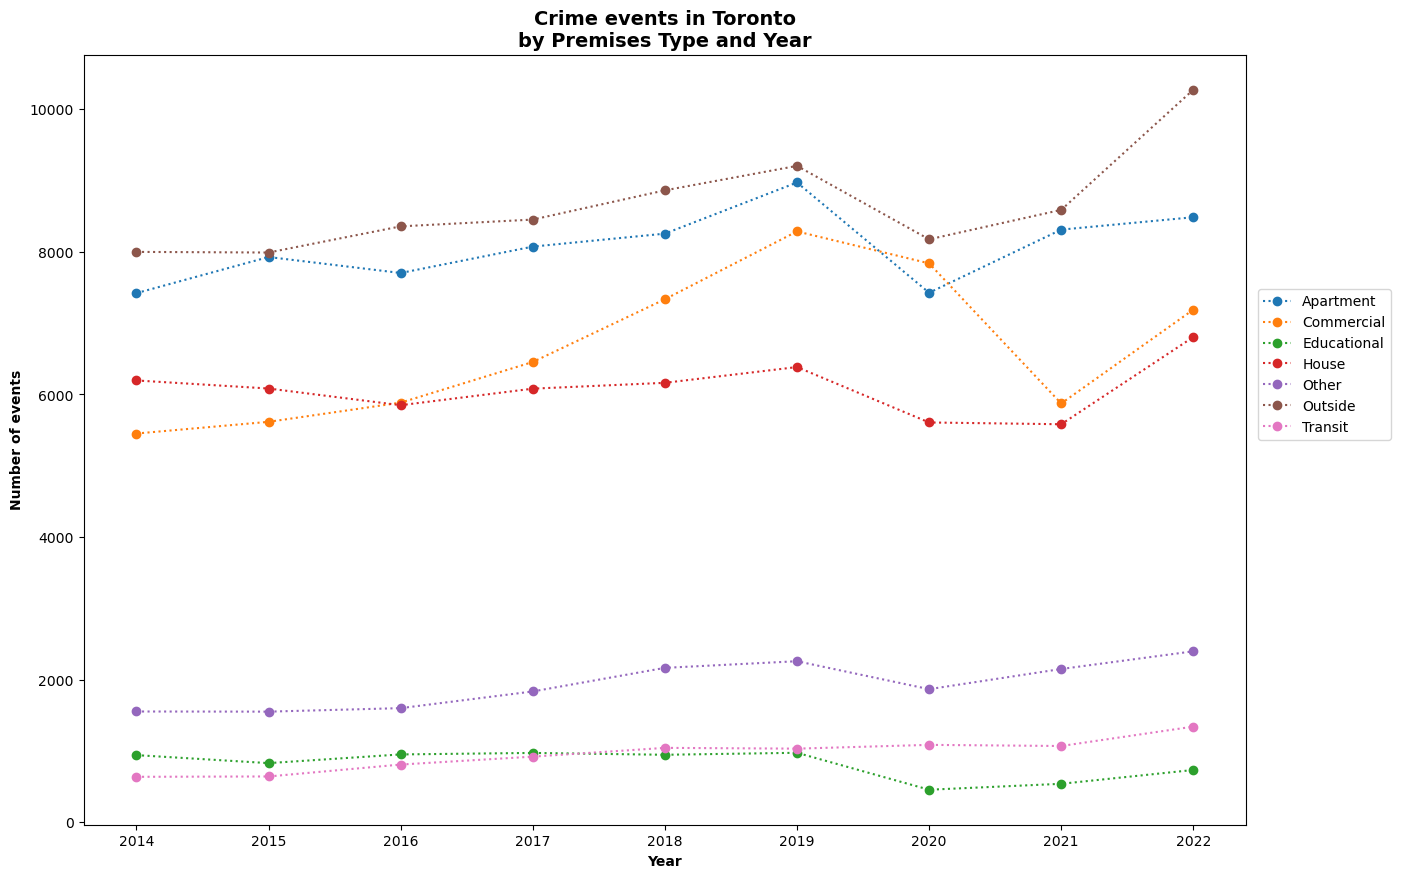

In [34]:
# Visualize
min_count = 0
max_count = max(year_premises_count['Number of events']) + 1
# max_count = 100


fig, ax = plt.subplots(figsize=(15, 10))


# List of premises types
premises = list(year_premises_count['Premises Type'].unique())

for prem in premises:
    this_data = year_premises_count.loc[year_premises_count['Premises Type'] == prem]

    if any(this_data['Number of events'] < min_count):
        continue
    elif any(this_data['Number of events'] > max_count):
        continue
    else:  # add this nhto plot
        ax.plot(
            this_data['Year'],
            this_data['Number of events'],
            'o:',
            label=prem
        )

plt.xlabel('Year', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto\nby Premises Type and Year',
    fontdict={'weight': 700, 'size': 14}
)
plt.legend(loc=(1.01, 0.5))
plt.show()


## By location type

In [11]:
year_loc_count = (df
    .groupby(['Year', 'Premises Type', 'Location Type'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

year_loc_count

,Year,Premises Type,Location Type,Number of events
0,2014,Apartment,"Apartment (Rooming House, Condo)",7421
1,2014,Commercial,Bank And Other Financial Institutions (Money M...,191
2,2014,Commercial,Bar / Restaurant,1278
3,2014,Commercial,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",395
4,2014,Commercial,"Construction Site (Warehouse, Trailer, Shed)",193
...,...,...,...,...
437,2022,Transit,Ttc Street Car,71
438,2022,Transit,Ttc Subway Station,599
439,2022,Transit,Ttc Subway Train,175
440,2022,Transit,Ttc Subway Tunnel / Outdoor Tracks,4


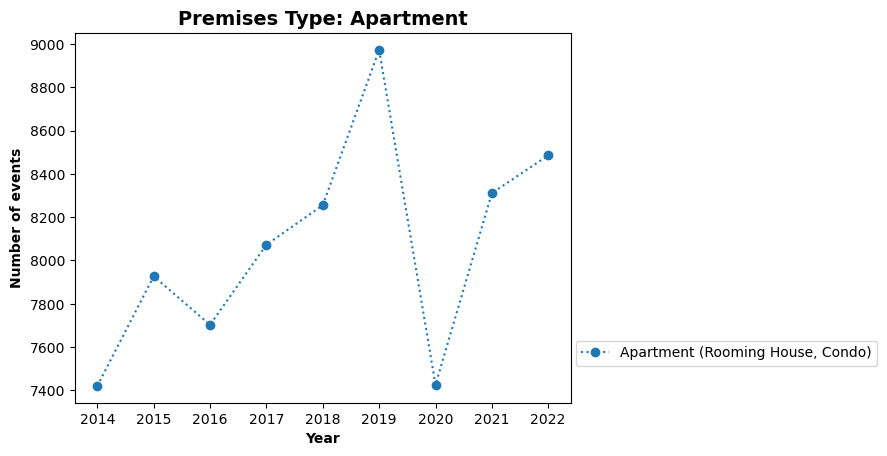

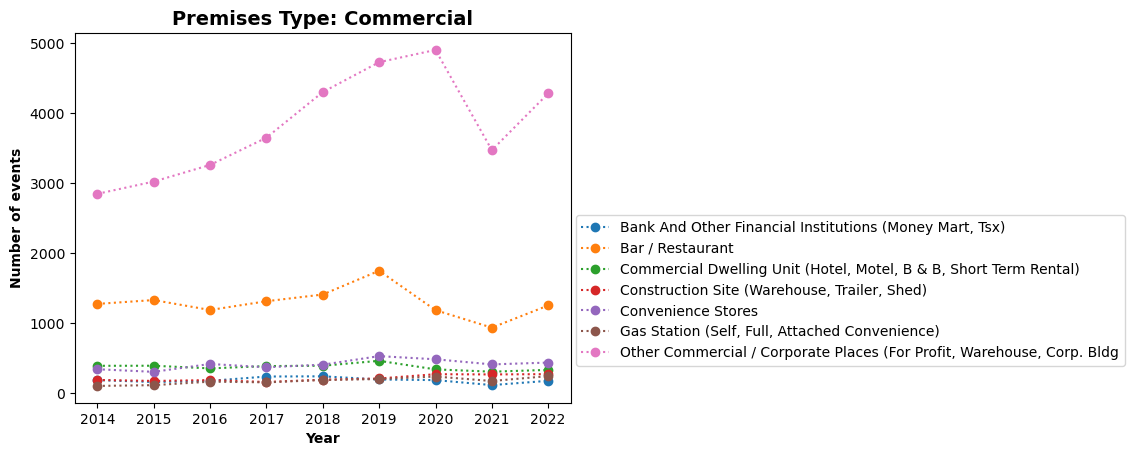

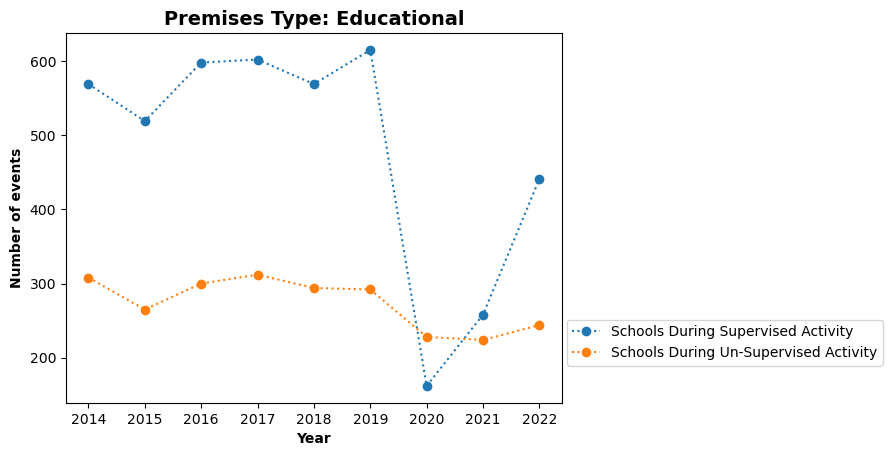

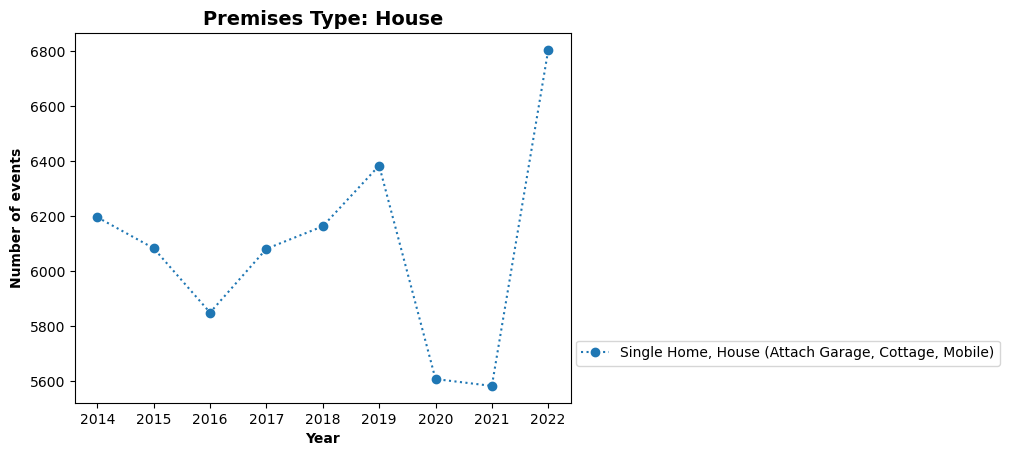

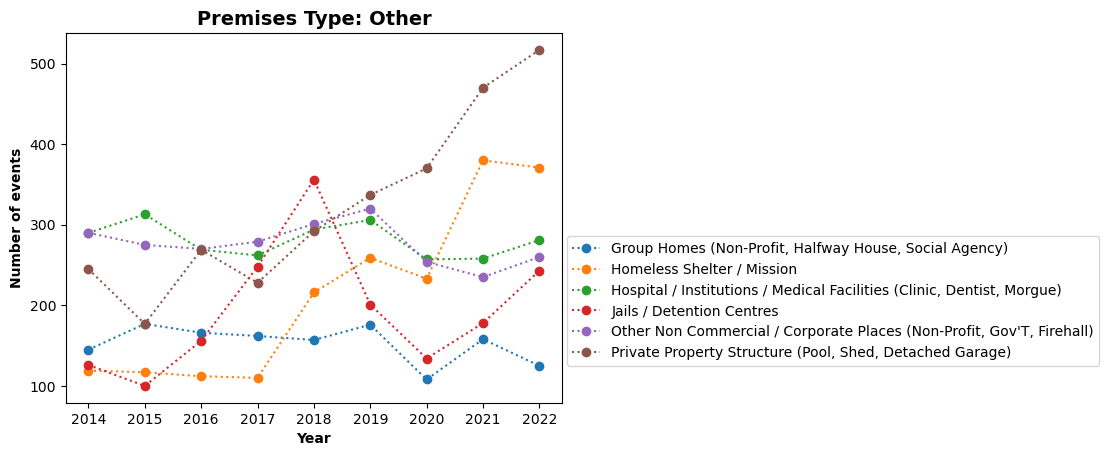

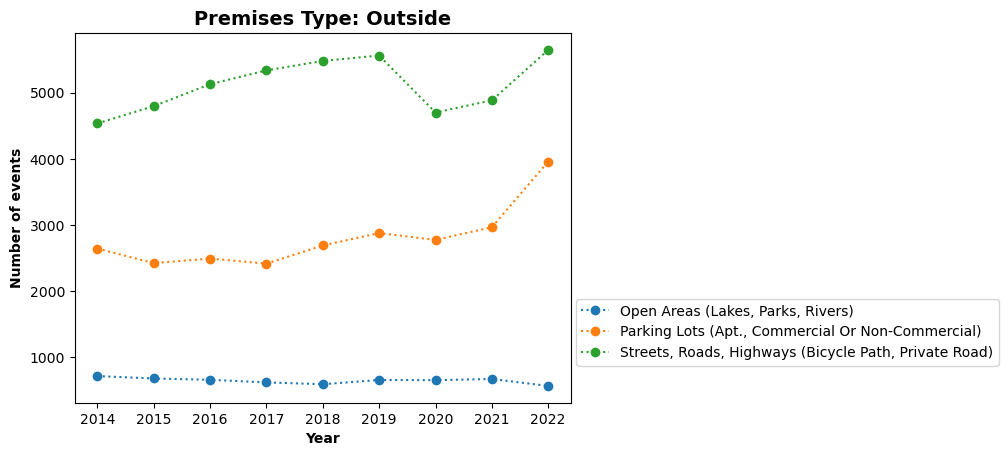

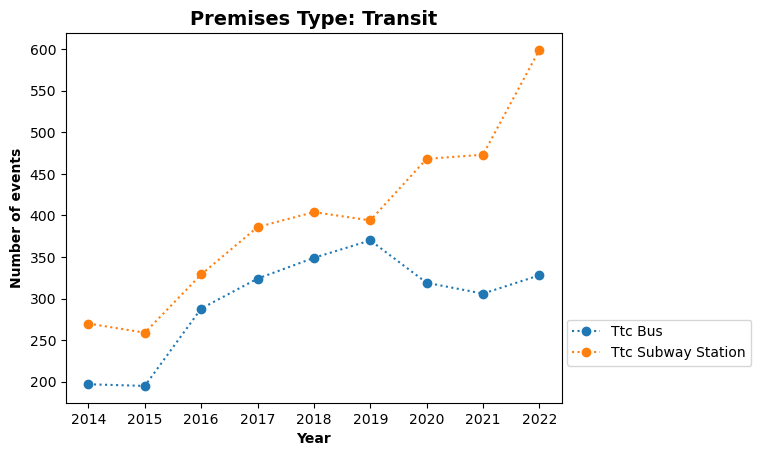

In [33]:
# Visualize
min_count = 100
max_count = max(year_loc_count['Number of events']) + 1
# max_count = 1000
premises = list(year_loc_count['Premises Type'].unique())
# one category for each plot
for prem in premises:
    this_data = year_loc_count.loc[year_loc_count['Premises Type'] == prem]

    locations = list(this_data['Location Type'].unique())

    for location in locations:
        this_loc_data = this_data.loc[this_data['Location Type'] == location]

        if any(this_loc_data['Number of events'] < min_count):
            continue
        elif any(this_loc_data['Number of events'] > max_count):
            continue
        else:
            # add this offence to plot
            plt.plot(
                this_loc_data['Year'],
                this_loc_data['Number of events'],
                'o:',
                label=location
            )


    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.legend(loc=(1.01, 0.1))
    plt.title(
        'Premises Type: ' + prem,
        fontdict={'weight': 700, 'size': 14}
    )
    plt.xlabel('Year', fontdict={'weight': 700})
    plt.ylabel('Number of events', fontdict={'weight': 700})

    plt.show()
    
